# Sentiment Analysis on Twitter Dataset


# Import Libraries

In [146]:
#Data preprocessing tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np 
import pandas as pd
import re       
import emoji
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import string 
import csv

#NLP(Natural Language Processing) tools
import nltk
#nltk.download("stopwords")
#nltk.download("wordnet")
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer
from nltk import WordNetLemmatizer

#Model training and building tools
import sklearn
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
from sklearn import set_config
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#imbalance data tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

#Designing tools
from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')
from time import time


# Exploratory Data Analysis

In [2]:
df_train=pd.read_csv("sentiment_train.csv")

In [3]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_train.drop("id",axis=1,inplace=True)
df_train.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
df_train.shape

(31962, 2)

In [6]:
df_train.isnull().sum()

label    0
tweet    0
dtype: int64

In [7]:
print("Totally there are {} duplicated values in train_set".format(df_train.duplicated().sum()))

Totally there are 2432 duplicated values in train_set


In [8]:
df_train= df_train.drop_duplicates(keep='first')

In [9]:
df_train.shape

(29530, 2)

In [10]:
df_prediction=pd.read_csv("sentiment_test.csv")

In [11]:
df_prediction.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [12]:
df_prediction.drop("id",axis=1,inplace=True)
df_prediction.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [13]:
df_prediction.shape

(17197, 1)

In [14]:
df_prediction.isnull().sum()

tweet    0
dtype: int64

In [15]:
print("Totally there are {} duplicated values in prediction_set".format(df_prediction.duplicated().sum()))

Totally there are 1067 duplicated values in prediction_set


In [16]:
df_prediction = df_prediction.drop_duplicates(keep='first')

In [17]:
df_prediction.shape

(16130, 1)

In [18]:
df_prediction.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [19]:
# WE WILL INSERT A NAN COLUMN NAMED LABEL BETWEEN ID AND TWEET 
df_prediction.insert(loc=0,column="label",value=np.nan)

In [20]:
df_prediction.head()

,label,tweet
0,NaN,#studiolife #aislife #requires #passion #dedic...
1,NaN,@user #white #supremacists want everyone to s...
2,NaN,safe ways to heal your #acne!! #altwaystohe...
3,NaN,is the hp and the cursed child book up for res...
4,NaN,"3rd #bihday to my amazing, hilarious #nephew..."


In [21]:
print("In column named label 0 represents positive sentiments and 1 represents negative sentiment")

In column named label 0 represents positive sentiments and 1 represents negative sentiment


In [22]:
# no of tweets belong to the classes..
df_train.groupby("label").count().style.background_gradient(cmap = "viridis")


,tweet
label,
0,27517
1,2013


In [23]:
pos = 100*len(df_train.loc[df_train['label']==0,'label'])/len(df_train['label'])
neg = 100*len(df_train.loc[df_train['label']==1,'label'])/len(df_train['label'])
print(f'Percentage of Positive Sentiment tweets is {pos}')
print(f'Percentage of Negative Sentiment tweets is {neg}')
print('\nClearly, The data is heavily Imbalanced')

Percentage of Positive Sentiment tweets is 93.18320352184219
Percentage of Negative Sentiment tweets is 6.816796478157806

Clearly, The data is heavily Imbalanced


In [24]:
# Understanding the sentiments in the data #
df_train[df_train['label']==0].head(20) 
# Class 0 : shows the list of positive sentiments

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...
7,0,the next school year is the year for exams.ð...
8,0,we won!!! love the land!!! #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...


In [25]:
df_train[df_train["label"]==1].head(20)
#class 1 :shows the list of negative sentiment

,label,tweet
13,1,@user #cnn calls #michigan middle school 'buil...
14,1,no comment! in #australia #opkillingbay #se...
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'...
56,1,@user lets fight against #love #peace
68,1,ð©the white establishment can't have blk fol...
77,1,"@user hey, white people: you can call people '..."
82,1,how the #altright uses &amp; insecurity to lu...
111,1,@user i'm not interested in a #linguistics tha...


In [26]:
label_map={0:"Positive",1:"Negative"}
df_train["label"]=df_train["label"].map(label_map)
df_train.head()

,label,tweet
0,Positive,@user when a father is dysfunctional and is s...
1,Positive,@user @user thanks for #lyft credit i can't us...
2,Positive,bihday your majesty
3,Positive,#model i love u take with u all the time in ...
4,Positive,factsguide: society now #motivation


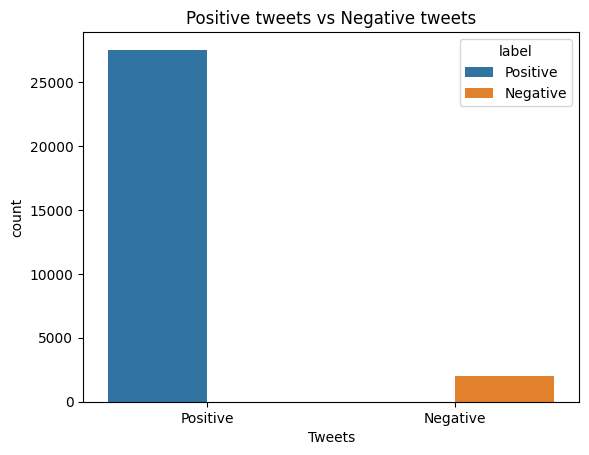

In [27]:
sns.countplot(data=df_train, x='label', hue='label')
plt.title('Positive tweets vs Negative tweets')
plt.xlabel('Tweets')
plt.show()

# Natural Language Processing

In [28]:
stop_words=set(stopwords.words('english'))

In [29]:
# Emoji tranformation
df=df_train
def deemoji(text):
    return emoji.demojize(text)
df= df.applymap(deemoji)
df.head()

,label,tweet
0,Positive,@user when a father is dysfunctional and is s...
1,Positive,@user @user thanks for #lyft credit i can't us...
2,Positive,bihday your majesty
3,Positive,#model i love u take with u all the time in ...
4,Positive,factsguide: society now #motivation


In [30]:
#avg_length_of_words
def avg_word(sentence):
    words = sentence.split()  
    if len(words)!=0:
        return (sum(len(word) for word in words)/len(words))
def avg_word_length(df):
    df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x))
    

In [31]:
# Hashtag counts
def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [32]:
# number of words count
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

In [33]:
# number of characters conts
def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x :sum(list(map(len,x.split(" ")))))

In [34]:
# number of numbers
def num_of_num(df):
    df["num_count"]=df["tweet"].apply(lambda x:len(x for x in x.split() if x.isdigit()))

In [35]:
# number of stopwords
def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [36]:
#number of uppercase words
def num_of_uppercase(df):
    df["upper_case"]=df["tweet"].apply(lambda x:len([x for x in x.split() if x.isupper()]))

In [37]:
def feature_extract(df):
    num_of_hash_tags(df)
    #num_of_num(df)
    num_of_chars(df)
    num_of_stop_words(df)
    num_of_uppercase(df)

In [38]:
#removing hyperlink , urls and markups
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result

In [39]:
#punctuation and symbol remove
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [40]:
#transforming into lowercase
def lower_case(df):
    df['Cleaned tweet'] = df['Cleaned tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [41]:
#stopwords remove
def stop_words_remove(df):
    df['Cleaned tweet'] = df['Cleaned tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [42]:
def remove_word_user(df):    
    df['Cleaned tweet'] = df['Cleaned tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

In [43]:
#spell correction
def spell_correction(df):
    df['Cleaned tweet']=df['Cleaned tweet'].apply(lambda x: str(TextBlob(x).correct()))

In [44]:
#lemmitization 
Word=WordNetLemmatizer()
def lemmatize(df):
    df['Cleaned tweet'] = df['Cleaned tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [45]:
#rare words removal
#lst = pd.Series(' '.join(df['tweet']).split()).value_counts()[-5:]
#lst = list(lst.index)
#def rare_words_removal(df):
   # df['Cleaned tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in lst))

In [117]:
def cleaning(df):
    df['Cleaned tweet'] = df['tweet'].apply(clean)
    df['Cleaned tweet'] = df['tweet'].apply(deemoji)
    df['Cleaned tweet'] = df['Cleaned tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    avg_word_length(df)
    #rare_words_removal(df)
    #spell_correction(df)
    lemmatize(df)

In [118]:
feature_extract(df)
cleaning(df)

In [119]:
df.head()

,label,tweet,hashtags_count,char_count,stopwords_count,upper_case,Cleaned tweet,avg_word
0,0,@user when a father is dysfunctional and is s...,1,82,10,0,father dysfunctional selfish drag kid dysfunct...,4.555556
1,0,@user @user thanks for #lyft credit i can't us...,3,101,5,0,thanks lyft credit cant use cause dont offer w...,5.315789
2,0,bihday your majesty,0,17,1,0,bihday majesty,5.666667
3,0,#model i love u take with u all the time in ...,1,70,5,0,model love u take u time ur,4.928571
4,0,factsguide: society now #motivation,1,32,1,0,factsguide society motivation,8.000000


In [49]:
df.columns


Index(['label', 'tweet', 'hashtags_count', 'char_count', 'stopwords_count',
       'upper_case', 'Cleaned tweet', 'avg_word'],
      dtype='object')

(-0.5, 399.5, 199.5, -0.5)

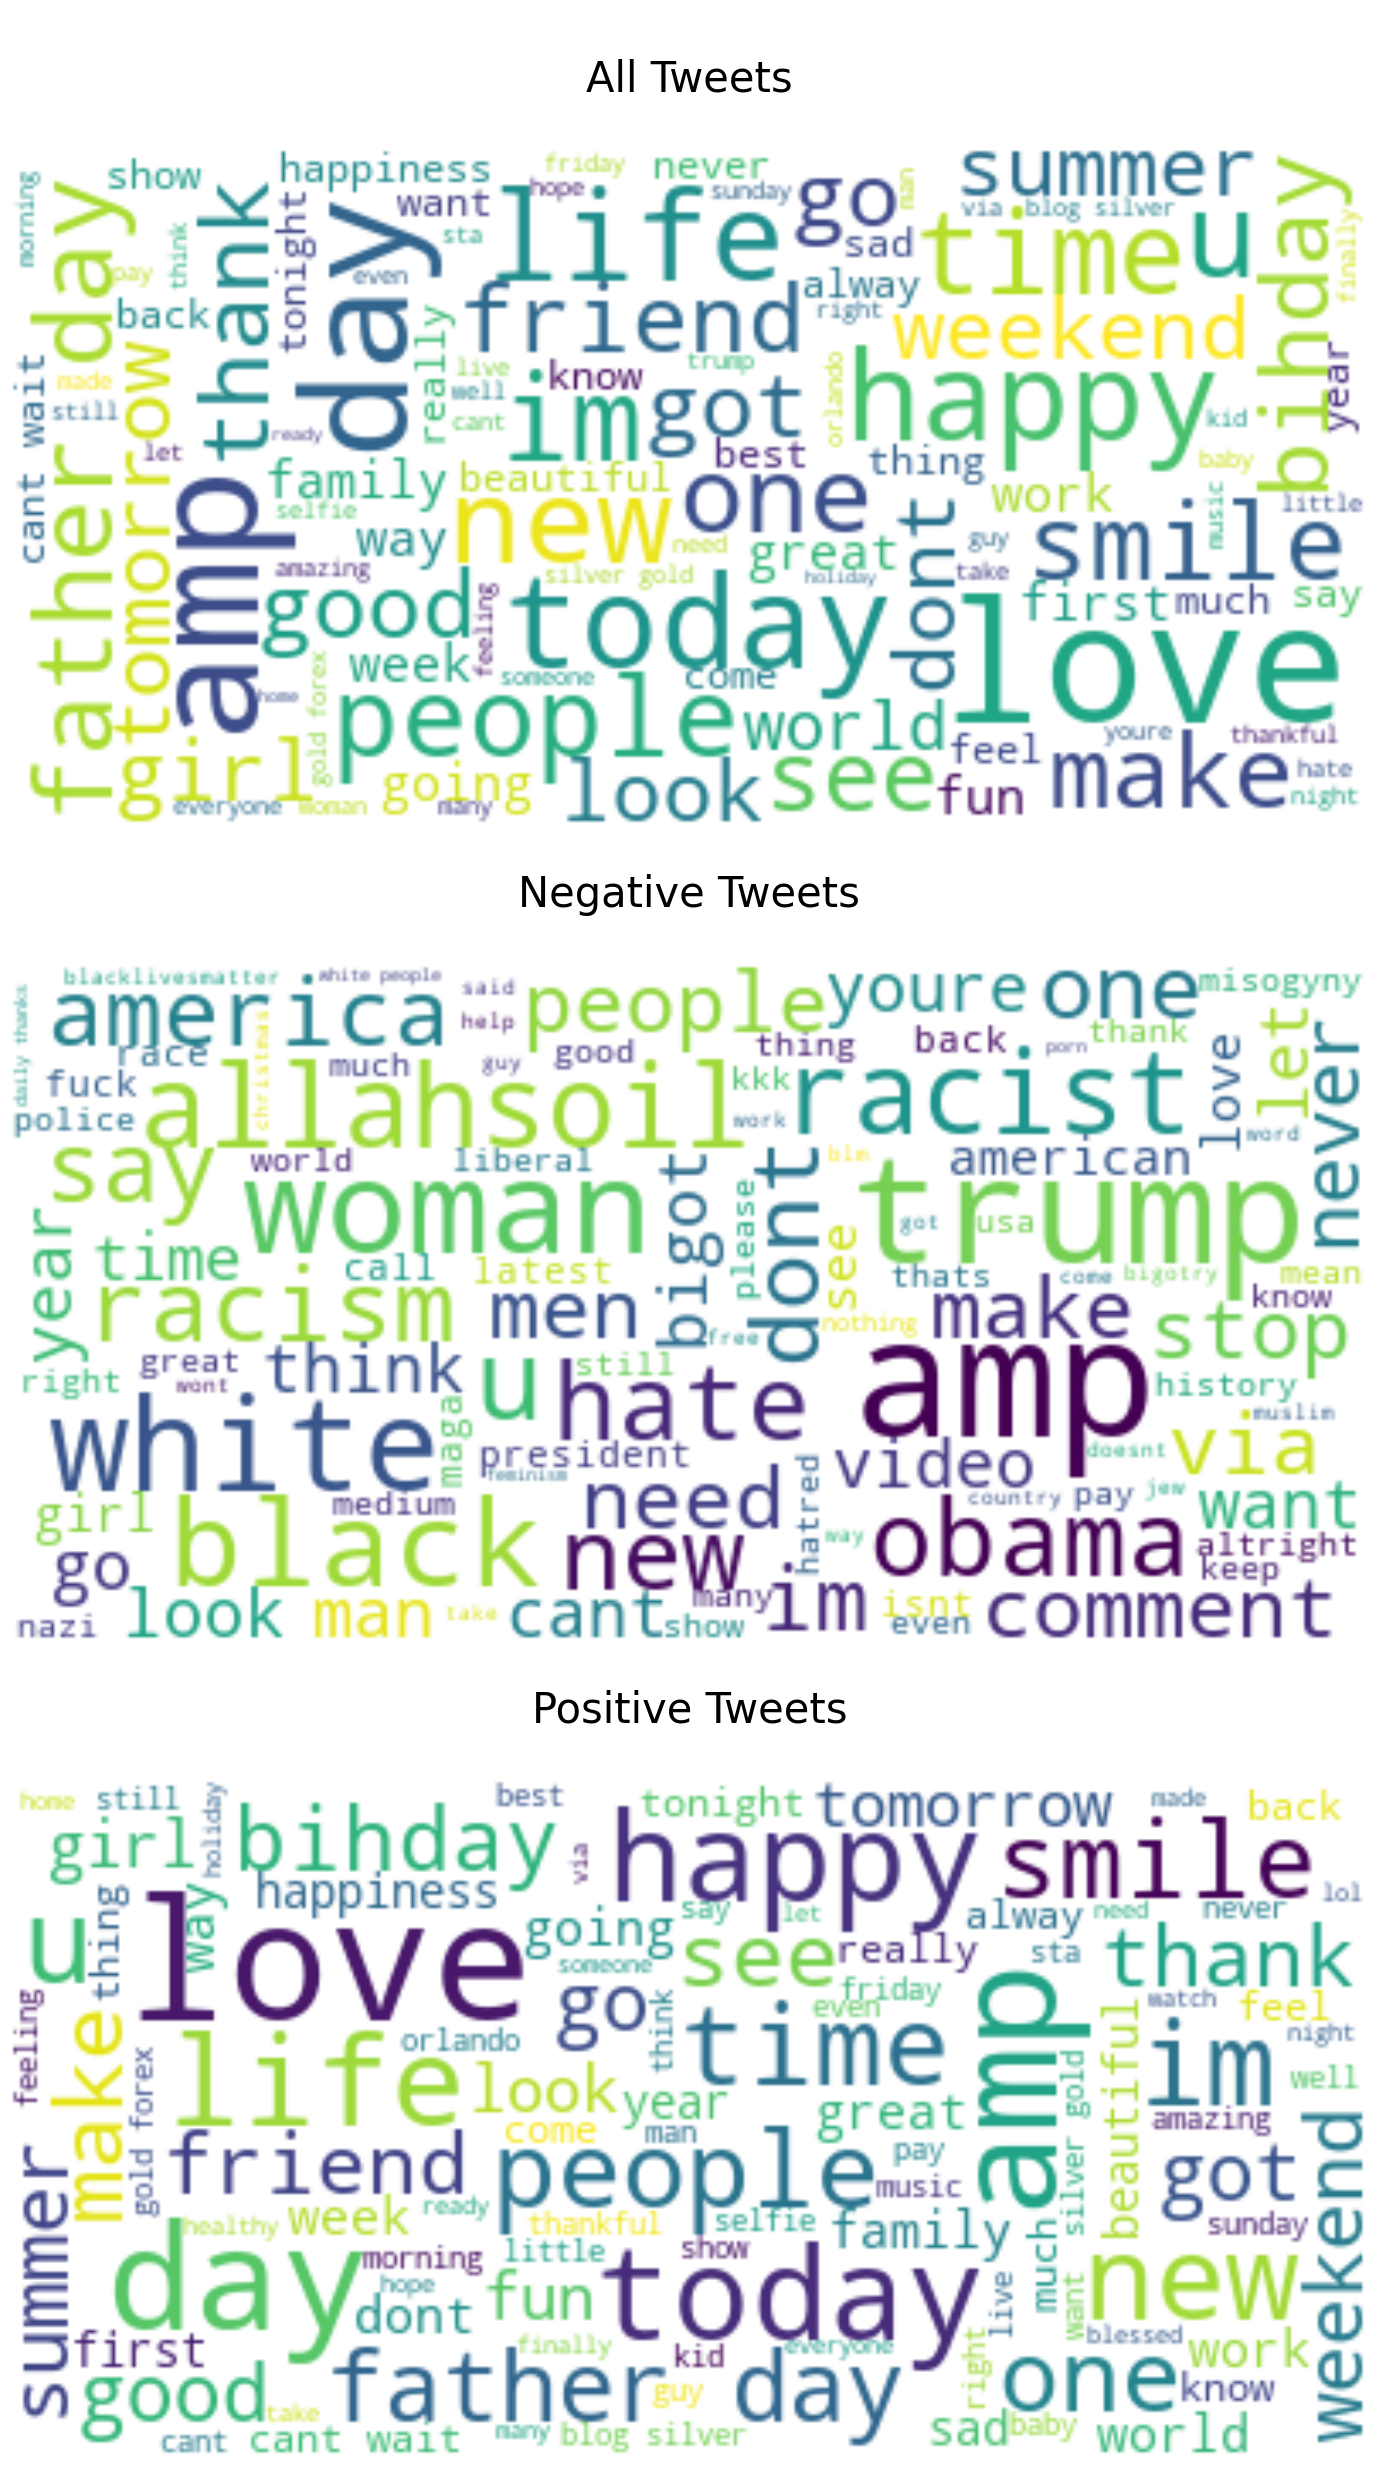

In [50]:
df_RS = df[df['label']=="Negative"]
df_NRS = df[df['label']=="Positive"]
tweet_All = " ".join(review for review in df['Cleaned tweet'])
tweet_RS = " ".join(review for review in df_RS['Cleaned tweet'])
tweet_NRS = " ".join(review for review in df_NRS['Cleaned tweet'])

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_RS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_RS)
wordcloud_NRS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NRS)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('\nAll Tweets\n', fontsize=30)
ax[0].axis('off')
print('\n')
ax[1].imshow(wordcloud_RS, interpolation='bilinear')
ax[1].set_title('\nNegative Tweets\n',fontsize=30)
ax[1].axis('off')
print('\n')
ax[2].imshow(wordcloud_NRS, interpolation='bilinear')
ax[2].set_title('\nPositive Tweets\n',fontsize=30)
ax[2].axis('off')

In [51]:
label_map={"Positive":0,"Negative":1}
df["label"]=df["label"].map(label_map)
df.head()

,label,tweet,hashtags_count,char_count,stopwords_count,upper_case,Cleaned tweet,avg_word
0,0,@user when a father is dysfunctional and is s...,1,82,10,0,father dysfunctional selfish drag kid dysfunct...,4.555556
1,0,@user @user thanks for #lyft credit i can't us...,3,101,5,0,thanks lyft credit cant use cause dont offer w...,5.315789
2,0,bihday your majesty,0,17,1,0,bihday majesty,5.666667
3,0,#model i love u take with u all the time in ...,1,70,5,0,model love u take u time ur,4.928571
4,0,factsguide: society now #motivation,1,32,1,0,factsguide society motivation,8.000000


# Model Building

In [52]:
X=df['Cleaned tweet']
Y=df["label"]

In [53]:
X.head()

0    father dysfunctional selfish drag kid dysfunct...
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                          model love u take u time ur
4                        factsguide society motivation
Name: Cleaned tweet, dtype: object

In [54]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [55]:
print(X.shape)
print(Y.shape)

(29530,)
(29530,)


In [56]:
X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, test_size = 0.30, shuffle = True,stratify=Y, random_state = 11)
print(colored("\nDIVIDED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DIVIDED SUCCESFULLY...


In [57]:
X_train.shape

(20671,)

In [58]:
pos = 100*len(Y_train[Y_train==0])/len(Y_train)
neg = 100*len(Y_train[Y_train==1])/len(Y_train)
print(f'Percentage of Positive Sentiment tweets is {pos}')
print(f'Percentage of Negative Sentiment tweets is {neg}')
print('\nClearly, after spliting the dataset in training and testing set the data is distributed as it was earlier.')

Percentage of Positive Sentiment tweets is 93.18368729137438
Percentage of Negative Sentiment tweets is 6.816312708625611

Clearly, after spliting the dataset in training and testing set the data is distributed as it was earlier.


# Vectorizing The Data

1. Bag of Words Method


In [59]:
vectorizer = CountVectorizer(binary=True,ngram_range=(1,1))
vectorizer.fit(X_train)
X_train_count = vectorizer.transform(X_train)
X_test_count = vectorizer.transform(X_test)
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [60]:
X_train_count.astype(float)

<20671x29415 sparse matrix of type '<class 'numpy.float64'>'
	with 154142 stored elements in Compressed Sparse Row format>

In [61]:
X_train_count.shape

(20671, 29415)

In [62]:
X_test_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [63]:
X_test_count.astype(float)

<8859x29415 sparse matrix of type '<class 'numpy.float64'>'
	with 58057 stored elements in Compressed Sparse Row format>

In [64]:
vectorizer1 = CountVectorizer(binary=True,ngram_range=(1,1))
X_count=vectorizer1.fit_transform(X)
X_count.astype(float)

<29530x37119 sparse matrix of type '<class 'numpy.float64'>'
	with 220467 stored elements in Compressed Sparse Row format>

In [65]:
Y_count=Y.copy()
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('over',over)]
pipeline = PL(steps=steps)

X_count, Y_count = pipeline.fit_resample(X_count, Y_count)



In [66]:
Y_train_count=Y_train.copy()
Y_test_count=Y_test.copy()
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('over',over)]
pipeline = PL(steps=steps)

X_train_count, Y_train_count = pipeline.fit_resample(X_train_count, Y_train_count)

X_test_count, Y_test_count = pipeline.fit_resample(X_test_count, Y_test_count)

In [67]:
X_train_count.shape

(38524, 29415)

2.TF-IDF method

In [68]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train)

X_train_tf_idf_word = tf_idf_word_vectorizer.transform(X_train)
X_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test)

X_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
X_test_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
tf_idf_word_vectorizer1 = TfidfVectorizer()
X_tf_idf=tf_idf_word_vectorizer1.fit_transform(X)
X_tf_idf.astype(float)

<29530x37119 sparse matrix of type '<class 'numpy.float64'>'
	with 220467 stored elements in Compressed Sparse Row format>

In [71]:
Y_tf_idf=Y.copy()
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('over',over),('under',under)]
pipeline = PL(steps=steps)

X_tf_idf_word,Y_tf_idf= pipeline.fit_resample(X_tf_idf,Y_tf_idf)


In [72]:
Y_train_tf_idf=Y_train.copy()
Y_test_tf_idf=Y_test.copy()
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')

steps = [('over',over),('under',under)]
pipeline = PL(steps=steps)

X_train_tf_idf_word,Y_train_tf_idf= pipeline.fit_resample(X_train_tf_idf_word,Y_train_tf_idf)

X_test_tf_idf_word, Y_test_tf_idf = pipeline.fit_resample(X_test_tf_idf_word,Y_test_tf_idf)

In [73]:
pos = 100*len(Y_train_count[Y_train_count==0])/len(Y_train_count)
neg = 100*len(Y_train_count[Y_train_count==1])/len(Y_train_count)
print(f'Percentage of Positive Sentiment tweets is {pos}')
print(f'Percentage of Negative Sentiment tweets is {neg}')
print('\nClearly,Now the data is balanced')

Percentage of Positive Sentiment tweets is 50.0
Percentage of Negative Sentiment tweets is 50.0

Clearly,Now the data is balanced


# Cross validation 

In [74]:
def cross_validate_data(model_list, X, y, cv=5):
    """
    Performs cross-validation on a given model using the specified dataset.

    Parameters:
        model (object): The model to be evaluated.
        X (array-like): The input features of the dataset.
        y (array-like): The target variable of the dataset.
        cv (int, optional): The number of folds in cross-validation. Default is 5.

    Returns:
        scores (array-like): Array of scores for each fold.
    """
    cross_results={}
    cross_final_results=[]
    for model in model_list:
        scores = cross_val_score(model, X, y, cv=cv)
        cross_results['Algorithm']=model.__class__.__name__
        cross_results['Cross Validation Score']=scores.mean()
        cross_final_results.append(cross_results.copy())
    return cross_final_results



In [75]:
models = [#MultinomialNB(),
DecisionTreeClassifier(),
LinearSVC(), AdaBoostClassifier(),
LogisticRegression() ,SGDClassifier(),#KNeighborsClassifier(),
XGBClassifier()]

In [76]:
res = cross_validate_data(models, X_count, Y_count)
results = pd.DataFrame(res)
results = results.reindex(columns = ['Algorithm','Cross Validation Score'])

In [77]:
results.sort_values(by = 'Cross Validation Score', inplace = True, ascending = False)

In [78]:
results.reset_index(drop = True)

,Algorithm,Cross Validation Score
0,LinearSVC,0.940437
1,SGDClassifier,0.938765
2,XGBClassifier,0.933478
3,LogisticRegression,0.932460
4,DecisionTreeClassifier,0.924447
5,AdaBoostClassifier,0.803267


In [79]:
res2 = cross_validate_data(models, X_tf_idf_word, Y_tf_idf)
results3 = pd.DataFrame(res2)

In [80]:
results3 = results3.reindex(columns = ['Algorithm','Cross Validation Score'])

In [81]:
results3.sort_values(by = 'Cross Validation Score', inplace = True, ascending = False)

In [82]:
results3.reset_index(drop = True)

,Algorithm,Cross Validation Score
0,DecisionTreeClassifier,0.967384
1,LinearSVC,0.957226
2,LogisticRegression,0.947105
3,SGDClassifier,0.934113
4,XGBClassifier,0.916161
5,AdaBoostClassifier,0.791783


# Model Selection

In [83]:
def pipeline(learner_list,train_x,train_y,test_x,test_y):
    '''
    inputs:
        - learner: the learning algorithm to be trained and predicted on
        - X_train: features training set
        - y_train: outcome training set
        - X_test: features testing set
        - y_test: outcome testing set
    '''
    # Get length of Training Data:
    size = len(train_y)
    results = {}
    final_results = []
    for learner in learner_list:
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__
        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(train_x,train_y)
        end = time() # Get end time
        # Store the training time
        results['Training Time'] = end - start
        start = time() # Get start time
        predictions_test = learner.predict(test_x)
        predictions_train = learner.predict(train_x)
        end = time() # Get end time
        # Store the prediction time
        results['Prediction Time'] = end - start
        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(test_y, predictions_test)
        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(train_y, predictions_train)
        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        final_results.append(results.copy())
        # Return a dataframe of the results
    return final_results

In [84]:
models = [MultinomialNB(),
DecisionTreeClassifier(),
LinearSVC(), AdaBoostClassifier(),
LogisticRegression(), SGDClassifier(),#KNeighborsClassifier(),
    XGBClassifier()]

In [85]:
ress = pipeline(models, X_train_tf_idf_word, Y_train_tf_idf, X_test_tf_idf_word,Y_test_tf_idf)
results = pd.DataFrame(ress)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Prediction Time','Accuracy: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 10.18 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.08 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 3.43 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 0.20 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.04 sec
----------------------------------------------------
Training XGBClassifier
Training XGBClassifier finished in 1.92 sec
----------------------------------------------------


In [86]:
results.sort_values(by = 'Accuracy: Test', inplace = True, ascending = False)

In [87]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Prediction Time,Accuracy: Train,Training Time
0,XGBClassifier,0.916233,0.048516,0.926799,1.924683
1,MultinomialNB,0.900303,0.005538,0.966696,0.008969
2,LogisticRegression,0.882253,0.002000,0.973809,0.197799
3,SGDClassifier,0.876196,0.001000,0.962491,0.038319
4,DecisionTreeClassifier,0.871472,0.031730,0.999351,10.184687
5,AdaBoostClassifier,0.847486,0.274806,0.784576,3.434902
6,LinearSVC,0.836523,0.001499,0.996885,0.080966


In [88]:
ress2 = pipeline(models, X_train_count, Y_train_count,X_test_count,Y_test_count)
results2 = pd.DataFrame(ress2)
results2 = results2.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Prediction Time','Accuracy: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 9.44 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.32 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 1.79 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 0.66 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.04 sec
----------------------------------------------------
Training XGBClassifier
Training XGBClassifier finished in 0.58 sec
----------------------------------------------------


In [89]:
results2.sort_values(by = 'Accuracy: Test', inplace = True, ascending = False)

In [90]:
results2.reset_index(drop = True)

,Algorithm,Accuracy: Test,Prediction Time,Accuracy: Train,Training Time
0,LinearSVC,0.936402,0.003496,0.996625,0.324626
1,SGDClassifier,0.932829,0.002001,0.975366,0.043010
2,LogisticRegression,0.929255,0.000999,0.971005,0.657739
3,XGBClassifier,0.917626,0.030007,0.947357,0.581536
4,DecisionTreeClassifier,0.897759,0.118199,0.998728,9.444460
5,AdaBoostClassifier,0.806663,0.260871,0.810949,1.794649
6,MultinomialNB,0.614113,0.007001,0.602430,0.014510


# Hyper parameter tuning

In [91]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000, 3000]
}

# Create a Linear SVC model
svc = LinearSVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_count, Y_train_count)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)


Best Hyperparameters:  {'C': 1, 'loss': 'hinge', 'max_iter': 2000, 'penalty': 'l2'}
Best Accuracy Score:  0.9349500061658389


In [92]:
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000]
}

# Create an SGDClassifier model
sgd = SGDClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_count, Y_train_count)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)


Best Hyperparameters:  {'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 3000, 'penalty': 'l1'}
Best Accuracy Score:  0.9384543050695324


In [124]:
svc = LinearSVC(penalty='l2',C= 1, loss= 'hinge', max_iter= 2000)

# Train the classifier on the training data
svc.fit(X_train_count, Y_train_count)

# Predict labels for the test set
y_pred = svc.predict(X_test_count)

# Calculate the accuracy of the model
accuracy = accuracy_score(Y_test_count, y_pred)
print("Accuracy:", accuracy)
print(classification_report(Y_test_count,y_pred))
cm=confusion_matrix(Y_test_count,y_pred)
cm

Accuracy: 0.9353119321623259
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      8255
           1       0.92      0.95      0.94      8255

    accuracy                           0.94     16510
   macro avg       0.94      0.94      0.94     16510
weighted avg       0.94      0.94      0.94     16510



array([[7592,  663],
       [ 405, 7850]], dtype=int64)

In [94]:
model = SGDClassifier(alpha= 0.0001, loss= 'modified_huber', max_iter= 3000, penalty= 'l1')
model.fit(X_train_count, Y_train_count)
y_pred = model.predict(X_test_count)
accuracy = accuracy_score(Y_test_count, y_pred)
print("Accuracy:", accuracy)
# Generate the classification report
report = classification_report(Y_test_count, y_pred)

print(report)
confusion_matrix(Y_test_count, y_pred)

Accuracy: 0.9224712295578438
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8255
           1       0.92      0.92      0.92      8255

    accuracy                           0.92     16510
   macro avg       0.92      0.92      0.92     16510
weighted avg       0.92      0.92      0.92     16510



array([[7595,  660],
       [ 620, 7635]], dtype=int64)

Therefore the best trained model is LinearSvc with 93.53% accuracy.

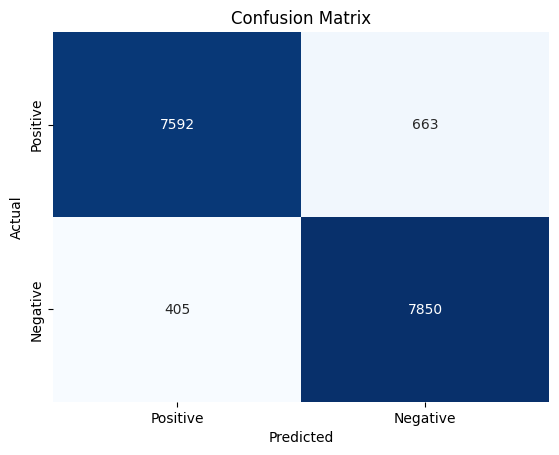

In [126]:
labels = ['Positive', 'Negative']

# Create color-coded confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Set x and y axis tick labels
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Show the plot
plt.show()

# Prediction

In [127]:
feature_extract(df_prediction)
cleaning(df_prediction)
df_prediction.head()

,label,tweet,hashtags_count,char_count,stopwords_count,upper_case,Cleaned tweet,avg_word
0,NaN,#studiolife #aislife #requires #passion #dedic...,7,79,1,0,studiolife aislife requires passion dedication...,8.777778
1,NaN,@user #white #supremacists want everyone to s...,4,82,4,0,white supremacist want everyone see new bird m...,5.125000
2,NaN,safe ways to heal your #acne!! #altwaystohe...,4,57,2,0,safe way heal acne altwaystoheal healthy healing,6.333333
3,NaN,is the hp and the cursed child book up for res...,3,119,8,0,hp cursed child book reservation already yes h...,5.409091
4,NaN,"3rd #bihday to my amazing, hilarious #nephew...",2,76,4,0,rd bihday amazing hilarious nephew eli ahmir u...,5.066667


In [128]:
df_pred_vec=vectorizer.transform(df_prediction['Cleaned tweet'])
df_pred_vec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [129]:
output_values=svc.predict(df_pred_vec)

In [130]:
output_values

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [131]:
df_prediction["label"]=output_values

In [135]:
label_map={0:"Positive",1:"Negative"}
df_prediction["label"]=df_prediction["label"].map(label_map)
df_prediction.head()

,label,tweet,hashtags_count,char_count,stopwords_count,upper_case,Cleaned tweet,avg_word
0,Negative,#studiolife #aislife #requires #passion #dedic...,7,79,1,0,studiolife aislife requires passion dedication...,8.777778
1,Positive,@user #white #supremacists want everyone to s...,4,82,4,0,white supremacist want everyone see new bird m...,5.125000
2,Positive,safe ways to heal your #acne!! #altwaystohe...,4,57,2,0,safe way heal acne altwaystoheal healthy healing,6.333333
3,Positive,is the hp and the cursed child book up for res...,3,119,8,0,hp cursed child book reservation already yes h...,5.409091
4,Positive,"3rd #bihday to my amazing, hilarious #nephew...",2,76,4,0,rd bihday amazing hilarious nephew eli ahmir u...,5.066667


In [139]:
df_final=df_prediction.iloc[:,:2]
df_final.head()

,label,tweet
0,Negative,#studiolife #aislife #requires #passion #dedic...
1,Positive,@user #white #supremacists want everyone to s...
2,Positive,safe ways to heal your #acne!! #altwaystohe...
3,Positive,is the hp and the cursed child book up for res...
4,Positive,"3rd #bihday to my amazing, hilarious #nephew..."


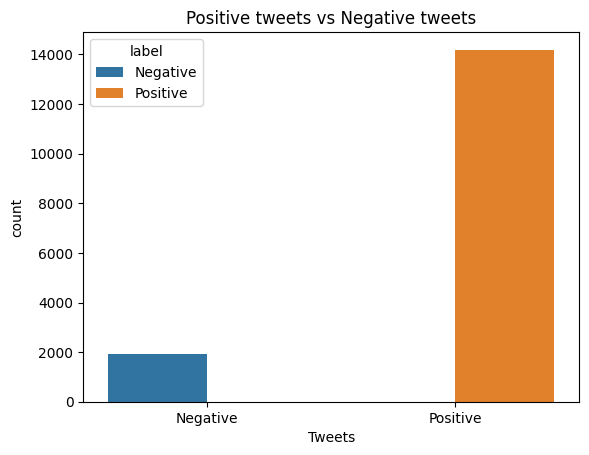

In [140]:
sns.countplot(data=df_final, x='label', hue='label')
plt.title('Positive tweets vs Negative tweets')
plt.xlabel('Tweets')
plt.show()

In [148]:
df_final.to_csv("final_submission.csv",index=False)

In [141]:
new_data={"label":[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan],
          "tweet":["you are so beautiful","Shut up you bloody criminal!!","I Quit","Bgmi is back","MS dhoni is the best captain of all time","CR7 is the biggest fraud","hello ! 😃 how are you ? I heard you got a job.nicee. "]
         }
new_data_df=pd.DataFrame(new_data)
feature_extract(new_data_df)
cleaning(new_data_df)
new_data_df

,label,tweet,hashtags_count,char_count,stopwords_count,upper_case,Cleaned tweet,avg_word
0,NaN,you are so beautiful,0,17,3,0,beautiful,4.250000
1,NaN,Shut up you bloody criminal!!,0,25,2,0,shut bloody criminal,5.000000
2,NaN,I Quit,0,5,0,1,quit,2.500000
3,NaN,Bgmi is back,0,10,1,0,bgmi back,3.333333
4,NaN,MS dhoni is the best captain of all time,0,32,4,1,m dhoni best captain time,3.555556
5,NaN,CR7 is the biggest fraud,0,20,2,1,cr biggest fraud,4.000000
6,NaN,hello ! 😃 how are you ? I heard you got a job....,0,40,5,1,hello grinningfacewithbigeyes heard got jobnicee,3.076923


In [142]:
new_data_vec = vectorizer.transform(new_data_df['Cleaned tweet'])
new_data_vec.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [143]:
output=svc.predict(new_data_vec)

In [144]:
output

array([0, 1, 1, 1, 0, 1, 0], dtype=int64)